# InsightML

## Library

In [228]:
import chardet
import csv
import itertools
import json
import numpy as np
import pandas as pd
import pandas_flavor as pf
import re
import ssl
import string
ssl._create_default_https_context = ssl._create_unverified_context
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="registration of accessor")
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)


from sklearn.neighbors import LocalOutlierFactor

from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

## Magic Format

In [229]:

def about_my_csv(filename):
    try: 
        # Ouvrir le fichier en mode lecture et détecter le format de délimitation de colonne
        with open(filename, 'r', newline='') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
        return dialect
    except:
        return None

def about_my_data(filename):
    # Déterminer le délimiteur
    with open(filename, 'r') as f:
        first_line = f.readline().rstrip('\n')
        # Utilisation de regex pour supprimer le contenu entre les guillemets
        first_line = re.sub(r'(["\'])(?:\\\1|.)*?\1', '', first_line)
        # Si il y a des espaces, c'est forcément entre deux colonnes
        if ' ' in first_line:
            delimiter = None
            space = True
        elif '\t' in first_line:
            delimiter = '\t'
            space = False
        else:
            delimiter = ','
            space = False
    return delimiter, space

def about_my_xls(filename):
    # Lire le fichier Excel en utilisant le module openpyxl et sans en-têtes de colonne
    df_temp = pd.read_excel(filename, engine='openpyxl', header=None)
    # Détecter le format de délimitation de colonne à l'aide de la fonction csv.Sniffer().sniff()
    dialect = csv.Sniffer().sniff(df_temp.to_csv(index=False, header=False))
    return dialect

def about_my_json(filename):
    # Lire le fichier Json pour récuperer la donnée
    with open(filename, 'r') as f:
        data = f.read()
    # Détecter le format du fichier JSON
    try:
        json.loads(data)
        orient = 'records'
    except ValueError:
        orient = 'columns'
    return orient

def about_my_h5(filename):
    # Lire les clés disponibles dans le fichier HDF5
    with pd.HDFStore(filename, mode='r') as store:
        keys = store.keys()

    # Trouver la clé correspondant au plus grand ensemble de données
    max_size = 0
    max_key = None
    for key in keys:
        size = pd.read_hdf(filename, key=key, stop=0).memory_usage(index=True, deep=True).sum()
        if size > max_size:
            max_size = size
            max_key = key
    return max_key

def rename_my_data(df):
    # Renommer les colonnes de AA à ZZ
    new_columns = {}
    for i, col in enumerate(df.columns):
        first_letter = string.ascii_uppercase[i // 26 - 1] if i >= 26 else ''
        second_letter = string.ascii_uppercase[i % 26]
        new_col_name = first_letter + second_letter if first_letter else second_letter
        new_columns[col] = new_col_name

    df = df.rename(columns=new_columns)
    return df


## Importation

In [230]:
list_path = ['Datasets/iris.data','Datasets/winequality-red.csv','Datasets/winequality-white.csv','Datasets/boston.data','Datasets/diabetes.csv','Datasets/breast-cancer-wisconsin.csv',
             'Datasets/heart_disease.csv','Datasets/abalone.data','Datasets/data_banknote_authentication.txt','Datasets/forestfires.csv','Datasets/ENB2012_data.xlsx', 
             'Datasets/airfoil_self_noise.dat','Datasets/Concrete_Data_Yeh.csv','Datasets/energydata_complete.csv','','',
             'Datasets/day.csv','Datasets/hour.csv','Datasets/kc_house_data.csv','Datasets/creditcard.csv','Datasets/UCI_HAR_Dataset.csv']

path_to_file = list_path[0]

extention = path_to_file.split('.')[-1]

if extention == 'csv':
    # Infos format about my csv.
    my_dialect = about_my_csv(path_to_file)
    # Make dataframe.
    df = pd.read_csv(path_to_file, dialect=my_dialect, on_bad_lines='skip')

elif extention in ['xls', 'xlsx','xlsm','xlsb']:
    # Make dataframe.
    df = pd.read_excel(path_to_file, engine='openpyxl')

elif extention == 'json':
    # Infos format about my json.
    my_orient = about_my_json(path_to_file)
    # Make dataframe.
    df = pd.read_json(path_to_file, orient=my_orient)

elif extention == 'h5':
    # Infos format about my json.
    my_key = about_my_h5(path_to_file)
    # Make dataframe
    df = pd.read_hdf(path_to_file, key=my_key, mode='r')

elif extention in ['data', 'dat','txt']:
    # Infos format about my csv.
    my_delimiter, space = about_my_data(path_to_file)
    # Make dataframe
    df = pd.read_csv(path_to_file, delimiter=my_delimiter, delim_whitespace=space, header=None)
    df = rename_my_data(df)

else: 
    print('format non pris en charge')
    print('Option à venir : SQL, Parquet, Feather, Pickle, HTML, XML')

filename = path_to_file.split('/')[-1]
print(f'Taille du dataset "{filename}" : {df.shape}')
df.head()

Taille du dataset "iris.data" : (150, 5)


,A,B,C,D,E
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Paramètre d'entrée

In [231]:
initial_size = df.shape

target_name = df.columns[-1]

## Pour l'ensemble de test, à supprimer par la suite 
if path_to_file == 'Datasets/breast-cancer-wisconsin.csv':
    target_name = 'diagnosis'
if path_to_file == 'Datasets/ENB2012_data.xlsx':
    df.drop(columns=['Y1'], inplace=True)
if path_to_file == 'Datasets/energydata_complete.csv':
    target_name = 'Appliances'
## *** ###

df.dropna(subset=target_name, inplace=True)

print(f'Taille dataset : {df.shape}')

Taille dataset : (150, 5)


## DateTime

In [232]:
# Définir la méthode 'detect_date' pour détecter les colonnes de texte contenant des dates
@pf.register_dataframe_method
def detect_date(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                print(f'"{col}" est une date.')
                df[col] = pd.to_datetime(df[col])
            except ValueError:
                pass
    return df

# Détecter et convertir les colonnes de texte en dates
df = df.detect_date()

"E" est une date.


In [233]:
# Identifier les colonnes de type datetime
date_cols = [col for col in df.columns if df[col].dtype == 'datetime64[ns]']

if len(date_cols) >= 2:
    # Normaliser les dates sur UTC
    for date_col in date_cols:
        df[date_col] = df[date_col].dt.tz_convert('Etc/UTC')

    # Créer toutes les combinaisons de colonnes de date
    list_date_cols = list(itertools.combinations(date_cols, 2))

    # Calculer la différence de temps entre chaque paire de colonnes de date
    for paire_date in list_date_cols:
        first_date = paire_date[0]
        second_date = paire_date[1]

        df[f'{first_date}_x_{second_date}'] = (df[second_date] - df[first_date]).dt.total_seconds()


# Extraire : Year, Day, WeekDay, Hour, Minute, Second, Microsecond
for date_col in date_cols:
    # Ajouter les colonnes pour chaque attribut de date
    df[f'{date_col}_year'] = df[date_col].dt.year
    df[f'{date_col}_day_of_year'] = df[date_col].dt.dayofyear
    df[f'{date_col}_day_of_week'] = df[date_col].dt.dayofweek
    df[f'{date_col}_hour'] = df[date_col].dt.hour
    df[f'{date_col}_minute'] = df[date_col].dt.minute
    df[f'{date_col}_second'] = df[date_col].dt.second
    df[f'{date_col}_microsecond'] = df[date_col].dt.microsecond

    df.drop(date_col, axis=1, inplace=True)
print(f'Taille dataset : {df.shape}')
df.head()

Taille dataset : (150, 5)


,A,B,C,D,E
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Supp Colonnes

In [234]:
# Filtrer la liste d'identifiants
df.drop(columns=list(filter(re.compile(r'.*(_id|-id| id|ID)$').match, df.columns)), errors='ignore', inplace=True)

# Supprime les colonnes Identifiant
df.drop(columns=['id', 'uid', 'ID', 'UID'], errors='ignore', inplace=True)

# Calcul du pourcentage de lignes vides pour chaque colonne
pourcentage_lignes_vides = df.isna().sum() / len(df)
# Sélection des colonnes à conserver (celles ayant moins de 30% de lignes vides)
colonnes_a_conserver = pourcentage_lignes_vides[pourcentage_lignes_vides <= 0.3].index
# Création d'un nouveau DataFrame ne contenant que les colonnes à conserver
df = df[colonnes_a_conserver]


# Booleen de liste ordonnée
def is_ordonne(lst):
    return all(lst[i] < lst[i+1] for i in range(len(lst)-1)) or all(lst[i] > lst[i+1] for i in range(len(lst)-1))
# Supprime les listes d'ordonnées
cols_to_drop = [col for col in df.columns if is_ordonne(df[col])]
df.drop(columns=cols_to_drop, inplace=True)

print(f'Taille dataset : {df.shape}')
df.head()

Taille dataset : (150, 5)


,A,B,C,D,E
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Supp lignes

In [235]:
## Supprime les lignes avec des données sporatiques
# Calculer le pourcentage de valeurs manquantes dans chaque ligne
missing_pct = df.isnull().sum(axis=1) / df.shape[1]
# Calculer le seuil de tolérance en nombre de colonnes sans valeurs
threshold = 0.15 * df.shape[1]
# Supprimer les lignes dont le nombre de colonnes sans valeurs est supérieur au seuil de tolérance
df = df.dropna(thresh=df.shape[1]-threshold)

print(f'Taille dataset : {df.shape}')

Taille dataset : (150, 5)


## Numerical

In [236]:

numeric_features = df.select_dtypes([np.number]).columns

for numerical in numeric_features:
    # Transforme en catégoriel quand moins de 8 valeurs différentes.
    if df[numerical].nunique() <= 8:
        df[numerical] = df[numerical].astype(str)

    # Supression valeurs manquantes au dessus de 10 %
    pourcentage_valeur_manquante = 100*df[numerical].isnull().sum()/len(df)
    if pourcentage_valeur_manquante >= 10:
        df.drop(numerical, axis=1, inplace=True)
        print(f'Supression de la colonne {numerical}')
print(f'Taille dataset : {df.shape}')

Taille dataset : (150, 5)


## Numerical Outliers

In [237]:
# Identify numeric columns
numeric_features = df.select_dtypes([np.number]).columns

def task(df):
    # Créez un modèle LOF
    lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    # Entraînez le modèle sur les données
    lof_model.fit(df[numeric_features])
    # Calculez les scores LOF pour chaque point de données
    lof_scores = lof_model.negative_outlier_factor_
    # supprime les points ayant un score LOF inférieur au 10ème percentile
    threshold = np.percentile(lof_scores, 10) 
    # Créez un masque booléen pour sélectionner les points qui sont en dessous du seuil
    outlier_mask = lof_scores > threshold
    # Sélectionnez les points qui ne sont pas des outliers
    return df.loc[outlier_mask, :]

def task_2(df):
    # Filter data based on 2 standard deviations
    for col in numeric_features:
        to_keep = (df[col] < df[col].mean() + 2*df[col].std()) & (df[col] > df[col].mean() - 2*df[col].std())
        return df.loc[to_keep,:]


if len(df) < 10000: df = task(df)
else: df = task_2(df)


print(f'Taille dataset : {df.shape}')

Taille dataset : (135, 5)


## Categoriel

In [238]:

categorical_features = df.select_dtypes("object").columns

for categorical in categorical_features:
    # Remplacement des valeurs nulles par la valeur "manquante"
    df[categorical] = df[categorical].fillna('manquante')

    ## Remplace les valeurs sporatique par la valeur "autre"
    counts = df[categorical].value_counts(normalize=True) # Calcul du pourcentage de chaque valeur dans la colonne
    mask = (counts < 0.1) # Sélection des valeurs qui représentent moins de 10% de la colonne
    df[categorical] = df[categorical].replace(counts[mask].index.tolist(), 'autre') # Remplacement des valeurs sélectionnées par la valeur "autre"

    # Suppression des colonnes contenant une seule valeur
    if df[categorical].nunique() == 1:
        df.drop(categorical, axis=1, inplace=True)
print(f'Taille dataset : {df.shape}')

Taille dataset : (135, 5)


#### Par la suite
* Détecter format carte bancaire, indicatif telephone...
* Convertir adresse en format lat.nlong
* Convertir les listes de mots en catégories quand c'est possible.
* ...

## Correction Prè-traitement

In [239]:
# Supprimer les lignes en double
df.drop_duplicates(inplace=True)
print(f'Taille dataset : {df.shape}')

Taille dataset : (132, 5)


## Séparation en variables explicative et cible

In [240]:
Y = df[:][target_name]
X = df.drop(columns=[target_name])
print(f'Taille X : {X.shape}')

Taille X : (132, 4)


## Suppr colonnes ultra corrélées

In [241]:
corr = X.corr()

high_corr_list = []
cols = corr.columns

for j in cols:
    for i, item in corr[j].iteritems():
        if (i!=j) and abs(item) > 0.9:
            high_corr_list.append((i,j))

no_keep = [high_corr_list[i][0] for i in range(len(high_corr_list)) if i%2 == 0]

X = X.drop(columns=no_keep)
print(f'Taille X : {X.shape}')

Taille X : (132, 3)


## Séparation en set d'entrainement & de test
Pour le rééquilibrage une meilleur approche est de faire attention :
à la précision, le rappel, la F1-score et l'aire sous la courbe ROC. 

In [242]:
target_dtype = df[target_name].dtype

# Cible Catégoriel
if np.issubdtype(target_dtype, np.object_):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0, stratify=Y)

    # calculer les pourcentages de chaque valeur unique et les trier par ordre décroissant
    pourcentages = df[target_name].value_counts(normalize=True) * 100
    pourcentages = pourcentages.sort_values(ascending=False)

    # Si l'écart entre la valeur majoritaire et minoritaire est supperieur à 10 %, enclenche le rééchantillonnage
    if pourcentages[0] - pourcentages[-1] > 10 :

        if len(pourcentages) > 2:
            my_sampling_strategy = 'not majority' # Équilibre des Classes 
        else : 
            my_sampling_strategy = 'majority' # Équilibre des valeurs Booleennes 

        oversample = RandomUnderSampler(sampling_strategy=my_sampling_strategy) # Rééchantillonnage 
        X_train, Y_train = oversample.fit_resample(X_train, Y_train)

# Cible Continue
else: 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)
print(f'Taille X : {np.concatenate((X_train, X_test)).shape}')

Taille X : (132, 3)


## Préprocessing Pipeline

In [243]:
# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur
print(f'Taille X : {np.concatenate((X_train, X_test)).shape}')

Taille X : (132, 3)


## Training Model 

In [244]:
## Define the model to be tuned
# Cible Catégoriel
if np.issubdtype(target_dtype, np.object_):
    modelRegression = LogisticRegression()
    modelForest = RandomForestClassifier()

# Cible Continue
else:
    modelRegression = LinearRegression()
    modelForest = RandomForestRegressor()

In [245]:
## Regression 
modelRegression.fit(X_train, Y_train)

LogisticRegression()

In [246]:
## SMV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm.SVC())
])

# Définir les paramètres pour la recherche de grille
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'poly', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Effectuer la recherche de grille pour trouver les meilleurs paramètres
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Utiliser les meilleurs paramètres pour entraîner le modèle SVM
modelSVC = grid_search.best_estimator_
modelSVC.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, kernel='linear'))])

In [247]:
## Random Forest
# Define the parameter grid
params = {
    'max_depth': range(4, 11),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 9),
    'n_estimators': range(10, 101, 10)
}

# Split the data into a smaller subset for initial testing
small_X_train, small_Y_train = X_train[:100], Y_train[:100]

# Run a randomized search with a smaller number of iterations
n_iter = 10
randomsearch = RandomizedSearchCV(modelForest, param_distributions=params, n_iter=n_iter, cv=2, n_jobs=-1)

# Fit the randomized search on the small dataset
randomsearch.fit(small_X_train, small_Y_train)

# Determine the best hyperparameters from the randomized search
best_params = randomsearch.best_params_

# Refine the parameter grid around the best hyperparameters
params = {
    'max_depth': np.arange(best_params['max_depth'] - 1, best_params['max_depth'] + 2),
    'min_samples_leaf': np.arange(best_params['min_samples_leaf'] - 1, best_params['min_samples_leaf'] + 2),
    'min_samples_split': np.arange(best_params['min_samples_split'] - 1, best_params['min_samples_split'] + 2),
    'n_estimators': np.arange(best_params['n_estimators'] - 20, best_params['n_estimators'] + 20, 10)
}

# Run a grid search with a smaller number of folds
cv = 2
gridsearch = GridSearchCV(modelForest, param_grid=params, cv=cv, n_jobs=-1)

# Fit the grid search on the full dataset
gridsearch.fit(X_train, Y_train)

# Determine the best hyperparameters from the grid search
best_params = gridsearch.best_params_


# Cible Catégoriel
if np.issubdtype(target_dtype, np.object_):
    modelForest = RandomForestClassifier(**best_params)
    
# Cible Continue
else:
    # Train a model on the best hyperparameters
    modelForest = RandomForestRegressor(**best_params)

modelForest.fit(X_train, Y_train)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
72 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-p

RandomForestClassifier(max_depth=4, min_samples_split=3, n_estimators=70)

## Predict Model

In [248]:
actual_size = pd.concat([X, Y], axis=1).shape
print(f"La taille du dataset était de {initial_size} lors de l'importation, il fait maintenant {actual_size}.")
print(f'Seulement {round(actual_size[0]/initial_size[0]*100, 2)} % des lignes sont utiles. \n')

La taille du dataset était de (150, 5) lors de l'importation, il fait maintenant (132, 4).
Seulement 88.0 % des lignes sont utiles. 



## Selection Model

In [249]:
import statistics as stat

def model_kind_score(target, description, Y_train, Y_test, Y_train_pred, Y_test_pred):
    # Cible Catégoriel
    if np.issubdtype(df[target].dtype, np.object_):
        score_train = accuracy_score(Y_train, Y_train_pred)
        score_test = accuracy_score(Y_test, Y_test_pred)
        kind = 'Accuracy'
    # Cible Continue
    else:
        score_train = r2_score(Y_train, Y_train_pred)
        score_test = r2_score(Y_test, Y_test_pred)
        kind = 'Rsquared'

    harmonic_mean = stat.harmonic_mean([score_train, score_test])

    print(f'Le score {kind} du modèle {description} \n\t sur le train : {score_train} \n\t sur le test  : {score_test}\n\t moy harmoniq : {harmonic_mean} \n')

    return [harmonic_mean, description, Y_train_pred, Y_test_pred]


In [250]:

list_models = [
    ['Regression', modelRegression],
    ['Support Vector Machine', modelSVC],
    ['Random Forest', modelForest]]

list_score_model = []

for model_info in list_models:
    description, modelML = model_info[0], model_info[1]

    # Cree les predictions
    Y_train_pred = modelML.predict(X_train)
    Y_test_pred = modelML.predict(X_test)

    # Calcule le score
    score_regression = model_kind_score(target_name, description, Y_train, Y_test, Y_train_pred, Y_test_pred)

    list_score_model.append(score_regression)
    

# Trie dans l'ordre décroissant et prend le plus grand
list_score_model = sorted(list_score_model, key=lambda x: x[0], reverse=True)
# Creer les paramétres pour la suite 
[model_score, model_type, show_train_pred, show_test_pred] = list_score_model[0]

print(f'Meilleur modele : \n\t {model_type}, avec une moyenne harmonique de : {model_score}')


Le score Accuracy du modèle Regression 
	 sur le train : 0.9642857142857143 
	 sur le test  : 0.95
	 moy harmoniq : 0.957089552238806 

Le score Accuracy du modèle Support Vector Machine 
	 sur le train : 0.9732142857142857 
	 sur le test  : 0.95
	 moy harmoniq : 0.9614670380687094 

Le score Accuracy du modèle Random Forest 
	 sur le train : 0.9732142857142857 
	 sur le test  : 0.95
	 moy harmoniq : 0.9614670380687094 

Meilleur modele : 
	 Support Vector Machine, avec une moyenne harmonique de : 0.9614670380687094


## Affichage

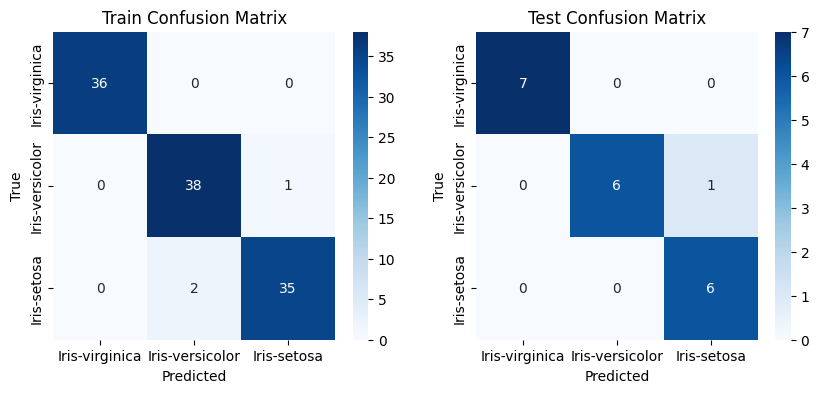

In [251]:
# Calculer la régression linéaire
def line_of(real, pred):
    m, b = np.polyfit(real, pred, 1)
    return m*real+b


# Cible Catégoriel
if np.issubdtype(target_dtype, np.object_):
    
    conf_matrix_train = confusion_matrix(Y_train, show_train_pred)
    conf_matrix_test = confusion_matrix(Y_test, show_test_pred)
    class_names = Y_test.unique().tolist()

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

    sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names, fmt='.6g')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title('Train Confusion Matrix')

    sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names, fmt='.6g')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title('Test Confusion Matrix')

    plt.show()

# Cible Continue
else:
    # Visualize the model
    colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)']
    fig = make_subplots(rows=1, cols=2)

    # Visualize predictions on training Set
    fig.add_trace(go.Scatter(x=Y_train, y=show_train_pred, mode='markers', name='Training Set', showlegend=False, marker=dict(color=colors[0])), row=1, col=1)
    fig.add_trace(go.Scatter(x=Y_train, y=line_of(Y_train, Y_train), mode='lines', name='Real', line=dict(color=colors[1])), row=1, col=1)
    fig.add_trace(go.Scatter(x=Y_train, y=line_of(Y_train, show_train_pred), mode='lines', name='Predict', line=dict(color=colors[0])), row=1, col=1)

    # Visualize predictions on test Set
    fig.add_trace(go.Scatter(x=Y_test, y=show_test_pred, mode='markers', name='Test Set', showlegend=False, marker=dict(color=colors[0])), row=1, col=2)
    fig.add_trace(go.Scatter(x=Y_test, y=line_of(Y_test, Y_test), mode='lines', name='Real', showlegend=False, line=dict(color=colors[1])), row=1, col=2)
    fig.add_trace(go.Scatter(x=Y_test, y=line_of(Y_test, show_test_pred), mode='lines', name='Predict', showlegend=False, line=dict(color=colors[0])), row=1, col=2)

    fig.update_layout(title_text=f"Training Set & Test Set with {model_type}")
    fig.show()